# How to Fetch Data from BigQuery Using Python API
To familiarize yourself with _bigquery concepts_, and _bigquery export schema_ for GA. You may get information here
1. BigQuery Concepts [https://cloud.google.com/bigquery/what-is-bigquery](https://cloud.google.com/bigquery/what-is-bigquery)
2. BigQuery Export Schema [https://support.google.com/analytics/answer/3437719?hl=en](https://support.google.com/analytics/answer/3437719?hl=en)
3. GCloud Python API [https://googlecloudplatform.github.io/gcloud-python/0.14.0/bigquery-usage.html](https://googlecloudplatform.github.io/gcloud-python/0.14.0/bigquery-usage.html)

### 1. Import necessary module
We need to import bigquery from gcloud and ServiceAccountCredentials from oauth2client.service_account

In [1]:
from gcloud import bigquery
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import matplotlib
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### 2. Create service account credentials from json key file
All request to bigquery API must be authenticated using service account or user id. We use service account authentication here to fetch data from bigquery. For the same purpose we need to create credentials object from key file. 

To know more about it visit [https://cloud.google.com/bigquery/authentication](https://cloud.google.com/bigquery/authentication)

In [2]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(filename="path/to/key-file.json")

### 3. Create bigquery client to execute queries, get datasets and tables

#### 3.1 Create Client
To create client we need to pass to mandatory parameter
1. Credentials - This is a oauth2client credentials object that is required to authenticate API call
2. Project - Project ID to which each API call is made

In [3]:
client = bigquery.Client(credentials = credentials, project='project_id')

#### 3.2 Get List of Datasets 
Make an API call to get all datasets in current project. Bigquery API call returns results in pages. When there is no more page `next_page_token` would be null, otherwise it is a pointer to next page result. 

In [4]:
datasets, next_page_token = client.list_datasets() # API Call
for dataset in datasets:
    print (dataset.name)

102325651
34831806
6052661
tmp


#### 3.3 Get All Tables in a Particular Dataset

In [5]:
tables, next_page_token = datasets[0].list_tables()
table_name = []
while True:
    for table in tables:
        table_name.append(table.name)
    if next_page_token:
        tables, next_page_token = datasets[0].list_tables(page_token=next_page_token)
    else:
        break

print('\n'.join(table_name[-10:]))

ga_sessions_20160811
ga_sessions_20160812
ga_sessions_20160813
ga_sessions_20160814
ga_sessions_20160815
ga_sessions_20160816
ga_sessions_20160817
ga_sessions_20160818
ga_sessions_20160819
ga_sessions_intraday_20160820


#### 3.4 Fetch Data From BigQuery
To fetch data we need to create a query string which is simply GBQ query. Thereafter we can invoke `client.run_sync_query` or `client.run_async_query` to get data from bigquery. The former runs in blocking/sync mode but the later will run in background and we need to poll the job status for the completion. 

##### TIP - It is suggested that always use maxResults, because in a single response bigquery can't return more than 10 MB of data. 
For more information on this limit visit [https://cloud.google.com/bigquery/docs/data#paging-through-list-results](https://cloud.google.com/bigquery/docs/data#paging-through-list-results)

In [6]:
query = '''
    SELECT 
        IF(totals.newvisits IS NULL, 'Returning User', 'New User') AS USER_TYPE,
        DATE,
        COUNT(totals.visits) SESSIONS,
        AVG(totals.pageviews) AS PAGE_DEPTH
    FROM
        TABLE_DATE_RANGE([34831806.ga_sessions_], TIMESTAMP('2016-07-01'), TIMESTAMP('2016-07-07'))
    GROUP BY
        USER_TYPE, DATE
    ORDER BY DATE, USER_TYPE
'''
query_result = client.run_sync_query(query)
query_result.run()

In [7]:
# Print schema information of the returned result
print (map(lambda x: (x.name, x.field_type), query_result.schema))
# print data in returned response
# Each row is represented by a tuple and entire result is just a python array of tuples
print ('\n'.join(map(str, query_result.rows)))

[(u'USER_TYPE', u'STRING'), (u'DATE', u'STRING'), (u'SESSIONS', u'INTEGER'), (u'PAGE_DEPTH', u'FLOAT')]
(u'New User', u'20160701', 924401, 4.984869956922758)
(u'Returning User', u'20160701', 2906356, 6.286320121678447)
(u'New User', u'20160702', 849042, 5.028440691141656)
(u'Returning User', u'20160702', 2738384, 6.132032899206007)
(u'New User', u'20160703', 896375, 5.432021250366761)
(u'Returning User', u'20160703', 2854690, 6.87257143758003)
(u'New User', u'20160704', 1013768, 5.602692958357789)
(u'Returning User', u'20160704', 3405384, 7.002611140120516)
(u'New User', u'20160705', 1084170, 5.822655595689182)
(u'Returning User', u'20160705', 3612524, 7.460852318612158)
(u'New User', u'20160706', 973246, 6.112778864648923)
(u'Returning User', u'20160706', 3350059, 7.240907500528408)
(u'New User', u'20160707', 975007, 6.1546255669265655)
(u'Returning User', u'20160707', 3305482, 7.255116242481453)


## Using Pandas to visualize BigQuery data
We have seen how to fetch bigquery data using gcloud api client. In this section we would learn how that data can be used to visualize bigquery for data analytics

#### Get list of users who have visited at least once for 25 or more days in a month along with when they visited for the first time and for the last time every day

In [8]:
query = '''
SELECT
  fullVisitorId,
  firstSession,
  lastSession,
  sessions,
  date
FROM (
  SELECT
    fullVisitorId,
    MIN(TIME(USEC_TO_TIMESTAMP(visitStartTime * 1000000))) firstSession,
    MAX(TIME(USEC_TO_TIMESTAMP(visitStartTime * 1000000))) lastSession,
    COUNT(totals.visits) AS sessions,
    date
  FROM
    TABLE_DATE_RANGE(
      [34831806.ga_sessions_], 
      TIMESTAMP('2016-07-01'), 
      TIMESTAMP('2016-07-31')
    )
  GROUP BY
    fullVisitorId,
    date
) AS t1
LEFT JOIN (
  SELECT
    uid
  FROM (
    SELECT
      fullVisitorId AS uid,
      COUNT(UNIQUE(DATE)) AS dailyVisitCount
    FROM
      TABLE_DATE_RANGE(
        [34831806.ga_sessions_], 
        TIMESTAMP('2016-07-01'), 
        TIMESTAMP('2016-07-31')
      )
    WHERE
      REGEXP_MATCH(hits.page.hostname, r'(bhaskar\.com|m\.bhaskar\.com|daily\.bhaskar\.com|m\.daily\.bhaskar\.com|divyamarathi\.bhaskar\.com)')
      AND NOT (hits.page.hostname CONTAINS 'divyabhaskar')
    GROUP BY
      uid
    HAVING 
      dailyVisitCount < 25
  )
  GROUP BY
    uid
) AS t2
ON 
  t1.fullVisitorId = t2.uid
WHERE 
  t2.uid IS NULL
ORDER BY 
  t1.fullVisitorId, 
  t1.date
LIMIT 
  1000
'''
query_result = client.run_sync_query(query)
query_result.run()

#### Create a pandas dataframe from query result. 

In [9]:
df = pd.DataFrame(data=query_result.rows, columns=map(lambda x: x.name, query_result.schema))
df.head(10)

,fullVisitorId,firstSession,lastSession,sessions,date
0,1000143991713939325,19:09:26,19:09:26,1,20160701
1,1000143991713939325,08:53:09,19:13:58,3,20160702
2,1000143991713939325,12:33:51,12:33:51,1,20160703
3,1000143991713939325,15:19:35,19:48:28,2,20160704
4,1000143991713939325,06:08:35,15:18:40,4,20160705
5,1000143991713939325,04:24:28,08:24:12,3,20160706
6,1000143991713939325,19:19:19,19:19:19,1,20160708
7,1000143991713939325,08:30:41,17:46:24,3,20160709
8,1000143991713939325,18:05:22,18:05:22,1,20160710
9,1000143991713939325,07:34:25,16:43:04,3,20160711


#### Get sessions, pageviews, users, and newUsers by date

In [10]:
query = '''
SELECT
  date,
  COUNT(totals.visits) AS sessions,
  SUM(totals.pageviews) AS pageviews,
  COUNT(UNIQUE(fullVisitorId)) AS users,
  COUNT(IF(totals.visits IS NULL, null, totals.newVisits)) AS newUsers
FROM
  TABLE_DATE_RANGE([34831806.ga_sessions_], TIMESTAMP('2016-07-01'), TIMESTAMP('2016-07-31')) 
GROUP BY 
  date
ORDER BY
  date
'''
query_result = client.run_sync_query(query)
query_result.run()

In [11]:
df = pd.DataFrame(data=query_result.rows, columns=map(lambda x: x.name, query_result.schema))
df.head(5)

,date,sessions,pageviews,users,newUsers
0,20160701,3830757,22876116,2783969,924401
1,20160702,3587426,21059171,2596225,849042
2,20160703,3751065,24486223,2641661,896375
3,20160704,4419152,29523831,3072363,1013768
4,20160705,4696694,33261661,3223885,1084170


#### Lets plot sessions, users and pageviews on the same plot the see trends and correlation
It is intuitive and easy to observe that these metrics are highly correlated

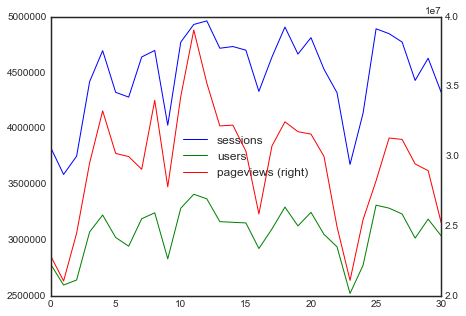

In [12]:
matplotlib.style.use('seaborn-white')
axis = df.plot.line(y='sessions')
axis = df.plot.line(y='users', ax=axis)
axis = df.plot.line(y='pageviews', secondary_y=True, ax=axis)
axis.figure.set_size_inches(7, 5)

#### Add some derived fields such as returning users, percentage of new and returning users

In [13]:
df['returningUsers'] = df['users'] - df['newUsers']
df['perNewUsers'] = df['newUsers'] / df['users'] * 100
df['perReturningUsers'] = df['returningUsers'] / df['users'] * 100
df.head(5)

,date,sessions,pageviews,users,newUsers,returningUsers,perNewUsers,perReturningUsers
0,20160701,3830757,22876116,2783969,924401,1859568,33.204429,66.795571
1,20160702,3587426,21059171,2596225,849042,1747183,32.702944,67.297056
2,20160703,3751065,24486223,2641661,896375,1745286,33.932249,66.067751
3,20160704,4419152,29523831,3072363,1013768,2058595,32.996361,67.003639
4,20160705,4696694,33261661,3223885,1084170,2139715,33.629301,66.370699


#### Stacked bar chart shows that percentage of new user by day for the 31 days period is almost constant

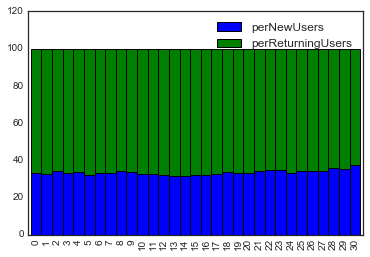

In [14]:
df[['date', 'perNewUsers', 'perReturningUsers']].plot.bar(stacked=True, width=1)

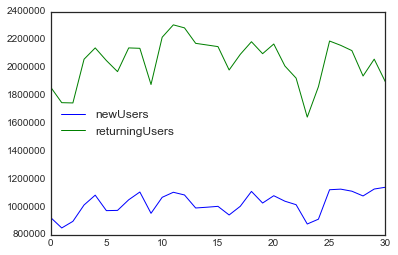

In [15]:
df[['date', 'newUsers', 'returningUsers']].plot.line()